In [32]:
import torch
print(torch.cuda.is_available())
torch.cuda.set_device(0) # SETS GPU AS DEFAULT FOR TENSORS AND OPERATIONS ON THEM

True


# Neural Networks:

## DNN with Dropout Classification:

In [12]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

In [3]:
def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

### Creating a nonlinearly separable Dataset:

In [4]:
class Data(Dataset):
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):
        a = np.matrix([-1,1,2,1,1,-3,1]).T
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        self.f = np.array(a[0] + (self.x) * a[1:3] + np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + np.multiply(self.x, self.x) * a[5:7]).flatten()
        self.a = a
       
        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        if train == True:
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)
        self.len = self.x.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot(self):
        X = dataset.x.numpy()
        y = dataset.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max() 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = dataset.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)
        
        plt.title('True decision boundary  and sample points with noise ')
        plt.plot(self.x[self.y == 0, 0].numpy(), self.x[self.y == 0,1].numpy(), 'bo', label='y=0') 
        plt.plot(self.x[self.y == 1, 0].numpy(), self.x[self.y == 1,1].numpy(), 'ro', label='y=1')
        plt.contour(xx, yy, f,cmap=plt.cm.Paired)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.legend()
    
    # Make a multidimension ploynomial function
    def multi_dim_poly(self, x):
        x = np.matrix(x)
        out = np.array(self.a[0] + (x) * self.a[1:3] + np.multiply(x[:, 0], x[:, 1]) * self.a[4] + np.multiply(x, x) * self.a[5:7])
        out = np.array(out)
        return out

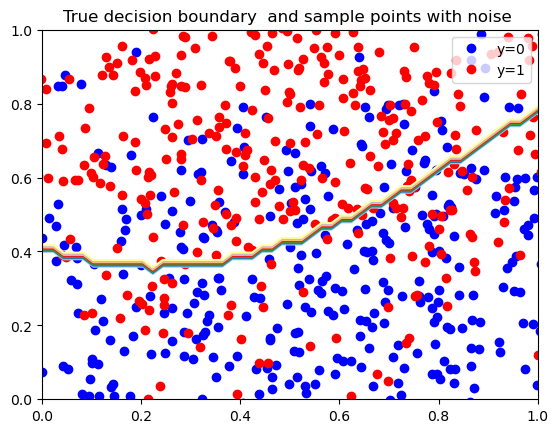

In [5]:
dataset = Data(noise_std=0.2)
dataset.plot()

In [6]:
torch.manual_seed(0)
validation_data = Data(train=False)

In [7]:
trainloader = DataLoader(dataset = dataset, batch_size=32)

### Create model, optimizer, loss function(cost):

In [8]:
# model with 1 hidden layer
class DropoutNet(nn.Module):
    def __init__(self, in_size, n_hidden, out_size, p = 0):
        super(DropoutNet, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
        self.drop = nn.Dropout(p=p)
        
    def forward(self, x):
        x = self.drop(F.relu(self.linear1(x)))
        x = self.drop(F.relu(self.linear2(x)))
        x = self.linear3(x)
        return x

In [ ]:
model = DropoutNet(2, 300, 2) # model without dropout
model_drop = DropoutNet(2, 300, 2, p=0.5) # model with dropout

In [ ]:
# Setting the dropout model to training phase:
model_drop.train()

In [ ]:
opti = torch.optim.Adam(model.parameters(), lr = 0.01)
opti_drop = torch.optim.Adam(model_drop.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
LOSS = {}
LOSS['training data no dropout'] = []
LOSS['training data dropout'] = []
LOSS['validation data no dropout'] = []
LOSS['validation data dropout'] = []

### Training the model:

In [ ]:
epochs = 500

def train_model(epochs):
    for epoch in range(epochs):
        if epoch%10==0:
            print(f"Training Epoch {epoch}/{epochs}...")
        yhat = model(dataset.x)
        yhat_drop = model_drop(dataset.x)
        loss = criterion(yhat, dataset.y)
        loss_drop = criterion(yhat_drop, dataset.y)
        
        #store the loss for both the training and validation data for both models 
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_data.x), validation_data.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_data.x), validation_data.y).item())
        model_drop.train()
        
        opti.zero_grad()
        opti_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        opti.step()
        opti_drop.step()

In [ ]:
train_model(epochs)

In [ ]:
model_drop.eval()

In [ ]:
# Print out the accuracy of the model without dropout

print("The accuracy of the model without dropout: ", accuracy(model, validation_data))

In [ ]:
# Print out the accuracy of the model without dropout

print("The accuracy of the model with dropout: ", accuracy(model_drop, validation_data))

In [ ]:
# Plot the LOSS

plt.figure(figsize=(6.1, 10))
def plot_LOSS():
    for key, value in LOSS.items():
        plt.plot(np.log(np.array(value)), label=key)
        plt.legend()
        plt.xlabel("iterations")
        plt.ylabel("Log of cost or total loss")

plot_LOSS()

## DNN with Dropout Regression:

In [19]:
# Import the libraries we need for the lab

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import optim

torch.manual_seed(0) 

In [25]:
class Data(Dataset):
    def __init__(self, N_SAMPLES=40, noise_std=1, train=True):
        self.x = torch.linspace(-1, 1, N_SAMPLES).view(-1, 1)
        self.f = self.x**2
        if train!=True:
            torch.manual_seed(1)
            self.y = self.f + noise_std*torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            torch.manual_seed(0)
            
        else:
            self.y = self.f + noise_std*torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
        self.len = self.x.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.len
    
    def plot(self):
        plt.figure(figsize=(10,15))
        plt.scatter(self.x.numpy(), self.y.numpy(), label="Samples")
        plt.plot(self.x.numpy(), self.f.numpy(), label = "True Function", color="orange")
        plt.xlabel("x")
        plt.ylabel("y")
#         plt.xlim((-1, 1))
#         plt.ylim((-2, 2.5))
        plt.legend(loc="best")
        plt.show()

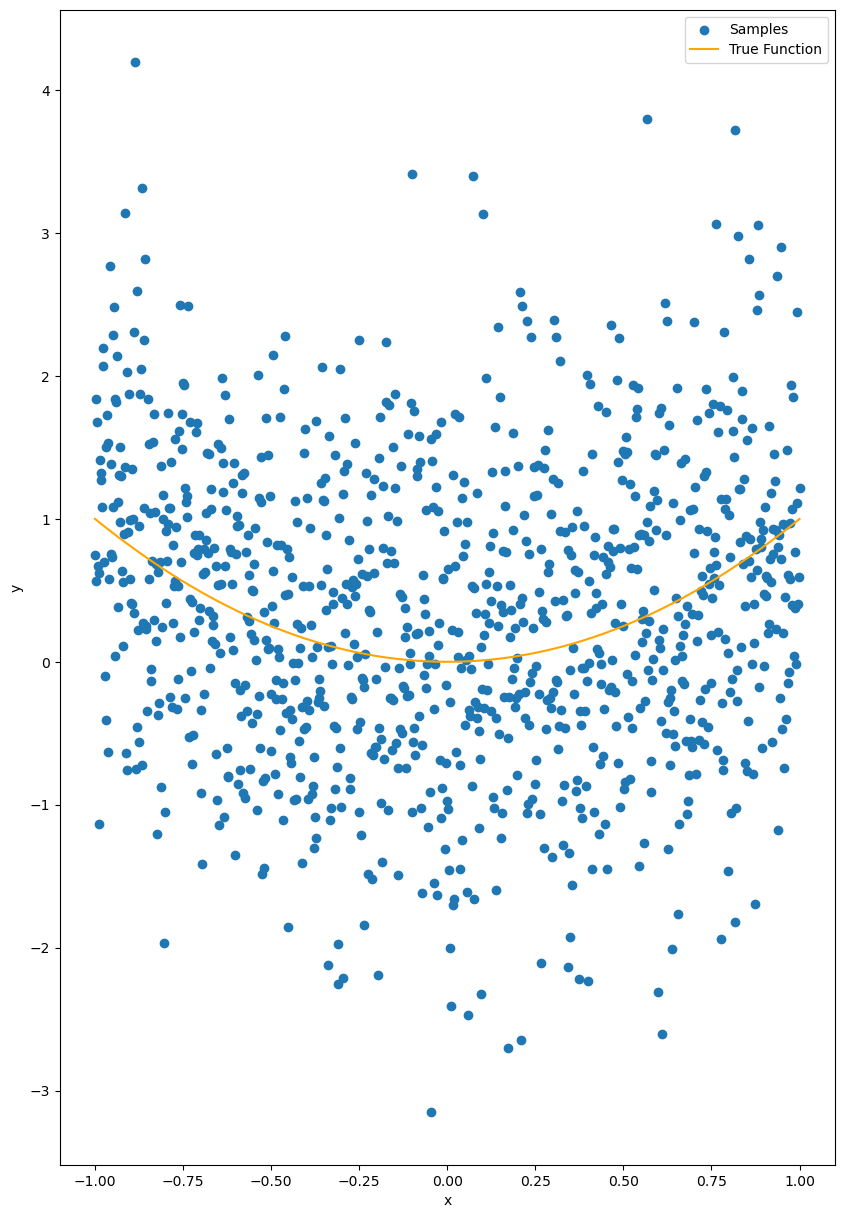

In [26]:
dataset = Data(N_SAMPLES=1000)
dataset.plot()

In [27]:
validation_set = Data(N_SAMPLES=200, train = False)

### Creating the model:

In [28]:
class Net(nn.Module):
    def __init__(self, in_size, n_hidden, out_size, p=0):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
        self.drop = nn.Dropout(p=p)
        
    def forward(self, x):
        x = F.relu(self.drop(self.linear1(x)))
        x = F.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        return x

In [41]:
model = Net(1, 300, 1)
model_drop = Net(1, 300, 1)

### Training the model using Mini-Batch Gradient Descent:

In [42]:
model_drop.train()

Net(
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
  (drop): Dropout(p=0, inplace=False)
)

In [43]:
opti = optim.SGD(model.parameters(), lr=0.01)
opti_drop = optim.SGD(model_drop.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [44]:
trainloader = DataLoader(dataset=dataset, batch_size = 32)

In [45]:
LOSS = {}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

In [48]:
epochs = 500

def train(epochs):
    for epoch in range(epochs):
        if epoch%10==0:
            print(f"Training epoch: {epoch}/{epochs}...")
        
        yhat = model(dataset.x)
        yhat_drop = model_drop(dataset.x)
        loss = criterion(yhat, dataset.y)
        loss_drop = criterion(yhat_drop, dataset.y)
        LOSS['training data no dropout'].append(loss.item())
        LOSS['training data dropout'].append(loss_drop.item())
        
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
        model_drop.train()
        
        opti.zero_grad()
        opti_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        opti.step()
        opti_drop.step()

In [49]:
train(epochs)

Training epoch: 0/500...
Training epoch: 10/500...
Training epoch: 20/500...
Training epoch: 30/500...
Training epoch: 40/500...
Training epoch: 50/500...
Training epoch: 60/500...
Training epoch: 70/500...
Training epoch: 80/500...
Training epoch: 90/500...
Training epoch: 100/500...
Training epoch: 110/500...
Training epoch: 120/500...
Training epoch: 130/500...
Training epoch: 140/500...
Training epoch: 150/500...
Training epoch: 160/500...
Training epoch: 170/500...
Training epoch: 180/500...
Training epoch: 190/500...
Training epoch: 200/500...
Training epoch: 210/500...
Training epoch: 220/500...
Training epoch: 230/500...
Training epoch: 240/500...
Training epoch: 250/500...
Training epoch: 260/500...
Training epoch: 270/500...
Training epoch: 280/500...
Training epoch: 290/500...
Training epoch: 300/500...
Training epoch: 310/500...
Training epoch: 320/500...
Training epoch: 330/500...
Training epoch: 340/500...
Training epoch: 350/500...
Training epoch: 360/500...
Training epo

In [50]:
model_drop.eval()

Net(
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
  (drop): Dropout(p=0, inplace=False)
)

In [51]:
yhat = model(dataset.x)
yhat_drop = model(dataset.x)

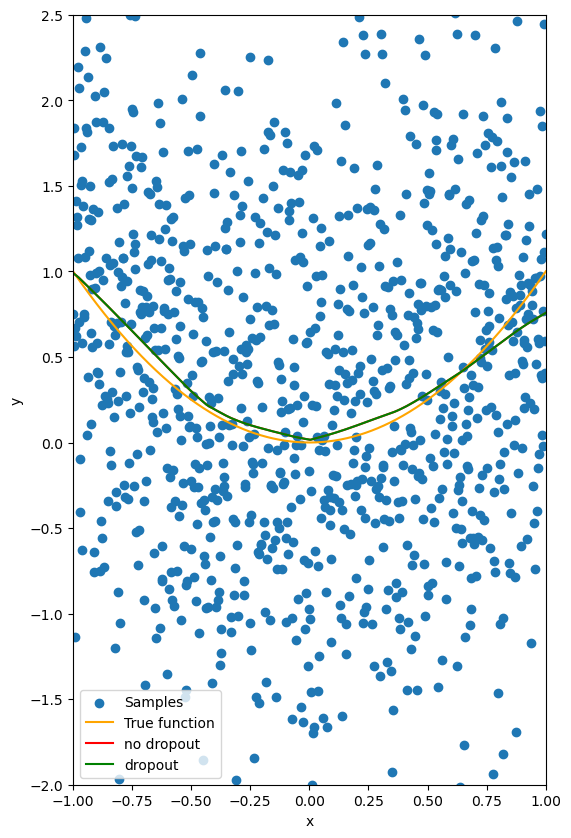

In [52]:
plt.figure(figsize=(6.1, 10))

plt.scatter(dataset.x.numpy(), dataset.y.numpy(), label="Samples")
plt.plot(dataset.x.numpy(), dataset.f.numpy(), label="True function", color='orange')
plt.plot(dataset.x.numpy(), yhat.detach().numpy(), label='no dropout', c='r')
plt.plot(dataset.x.numpy(), yhat_drop.detach().numpy(), label="dropout", c ='g')

plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend(loc = "best")
plt.show()

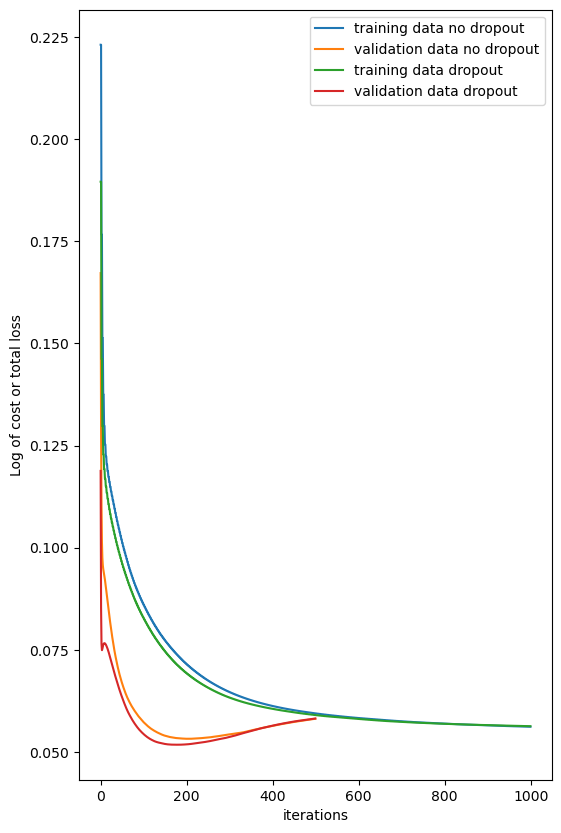

In [53]:
plt.figure(figsize=(6.1, 10))
for key, value in LOSS.items():
    plt.plot(np.log(np.array(value)), label=key)
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("Log of cost or total loss")

## Using Different Weight Initialization Methods:

In [25]:
# Import the libraries we need for this lab
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0)

### Xavier Initialised Model:

In [14]:
class Net_Xavier(nn.Module):
    def __init__(self, layers):
        super(Net_Xavier, self).__init__()
        self.hidden = nn.ModuleList()
        for in_size, out_size in zip(layers, layers[1:]):
            linear = nn.Linear(in_size, out_size)
            torch.nn.init.xavier_uniform_(linear.weight)
            self.hidden.append(linear)
            
    def forward(self, x):
        L = len(self.hidden) # number of hidden layers
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l<L-1:
                x = torch.tanh(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

### Uniformely Initialised Model:

In [15]:
class Net_Uniform(nn.Module):
    def __init__(self, layers):
        super(Net_Uniform, self).__init__()
        self.hidden = nn.ModuleList()
        
        for in_size, out_size in zip(layers, layers[1:]):
            linear = nn.Linear(in_size, out_size)
            torch.nn.init.uniform_(linear.weight)
            self.hidden.append(linear)
            
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transformation) in zip(range(L), self.hidden):
            if l<L-1:
                x = torch.tanh(linear_transformation(x))
            else:
                x = linear_transformation(x)
        return x

### He Initialised Model:

In [16]:
class Net_He(nn.Module):
    def __init__(self, layers):
        super(Net_He, self).__init__()
        self.hidden = nn.ModuleList()
        
        for in_size, out_size in zip(layers, layers[1:]):
            linear = nn.Linear(in_size, out_size)
            torch.nn.init.kaiming_uniform_(linear.weight)
            self.hidden.append(linear)
            
    def forward(self, x):
        L = len(self.hidden)
        for (l, lin_trans) in zip(range(L), self.hidden):
            if l<L-1:
                x = F.relu(lin_trans(x))
            else:
                x = lin_trans(x)
        return x

### Default Initialised Model:

In [17]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        
        for in_size, out_size in zip(layers, layers[1:]):
            linear = nn.Linear(in_size, out_size)
            self.hidden.append(linear)
            
    def forward(self, x):
        L = len(self.hidden)
        for (l, lin_trans) in zip(range(L), self.hidden):
            if l<L-1:
                x = F.relu(lin_trans(x))
            else:
                x = lin_trans(x)
        return x

### Train Function:

In [18]:
def train(model, criterion, dataloader, val_loader, optimizer, epochs=100):
    i = 0
    loss_acc = {'training_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        if epoch%5==0:
            print(f"Training epoch: {epoch}/{epochs}...")
        for i, (x,y) in enumerate(trainloader):
            yhat = model(x.view(-1, 28*28))
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_acc['training_loss'].append(loss.data.item())
        
        correct = 0
        for x,y in val_loader:
            yhat = model(x.view(-1, 28*28))
            _, label = torch.max(yhat, 1)
            correct+=(label==y).sum().item()
        accuracy = 100 * (correct/len(validation_dataset))
        loss_acc['val_loss'].append(accuracy)
    return loss_acc

### Creating Data:

In [19]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

In [20]:
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [21]:
trainloader = DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

### Define NN, Criterion, Optimizer and Training:

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
input_dim = 28*28
output_dim= 10
layers = [input_dim, 100, 200, 100, output_dim]

In [26]:
model = Net(layers)
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
training_results = train(model, criterion, trainloader, validation_loader, optimizer,epochs=30)

Training epoch: 0/30...
Training epoch: 5/30...
Training epoch: 10/30...
Training epoch: 15/30...
Training epoch: 20/30...
Training epoch: 25/30...


In [27]:
model_Uniform = Net_Uniform(layers)
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
training_results_Uniform = train(model_Uniform, criterion, trainloader, validation_loader, optimizer,epochs=30)

Training epoch: 0/30...
Training epoch: 5/30...
Training epoch: 10/30...
Training epoch: 15/30...
Training epoch: 20/30...
Training epoch: 25/30...


In [28]:
model_Xavier = Net_Xavier(layers)
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
training_results_Xavier = train(model_Xavier, criterion, trainloader, validation_loader, optimizer,epochs=30)

Training epoch: 0/30...
Training epoch: 5/30...
Training epoch: 10/30...
Training epoch: 15/30...
Training epoch: 20/30...
Training epoch: 25/30...


In [29]:
model_He = Net_He(layers)
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
training_results_He = train(model_He, criterion, trainloader, validation_loader, optimizer,epochs=30)

Training epoch: 0/30...
Training epoch: 5/30...
Training epoch: 10/30...
Training epoch: 15/30...
Training epoch: 20/30...
Training epoch: 25/30...


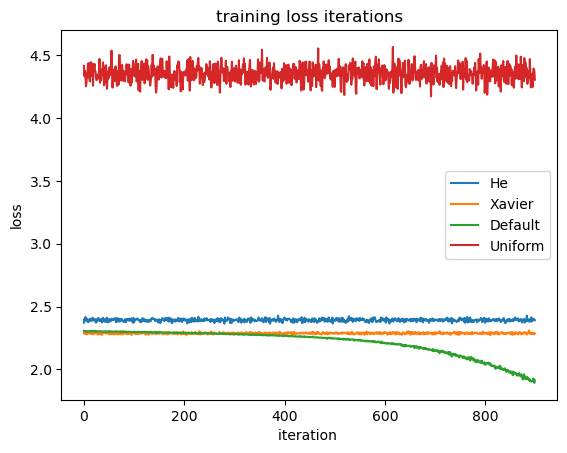

In [30]:
plt.plot(training_results_He['training_loss'], label='He')
plt.plot(training_results_Xavier['training_loss'], label='Xavier')
plt.plot(training_results['training_loss'], label='Default')
plt.plot(training_results_Uniform['training_loss'], label='Uniform')
plt.ylabel('loss')
plt.xlabel('iteration ') 
plt.title('training loss iterations')
plt.legend()

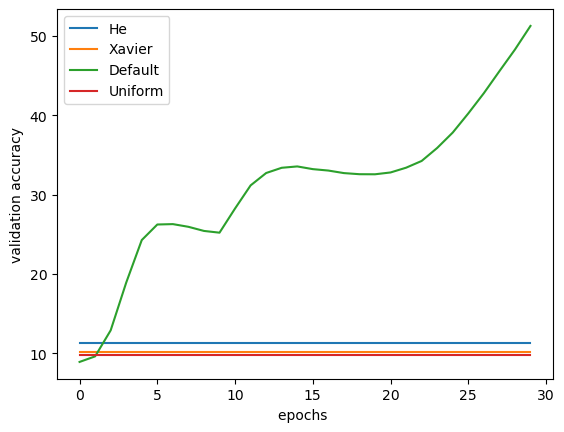

In [31]:
plt.plot(training_results_He['val_loss'], label='He')
plt.plot(training_results_Xavier['val_loss'], label='Xavier')
plt.plot(training_results['val_loss'], label='Default')
plt.plot(training_results_Uniform['val_loss'], label='Uniform') 
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')   
plt.legend()
plt.show()